In [1]:
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from dgl.nn import GraphConv
import dgl
import seaborn as sns

/home/mi22a004/anaconda3/envs/DGL/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


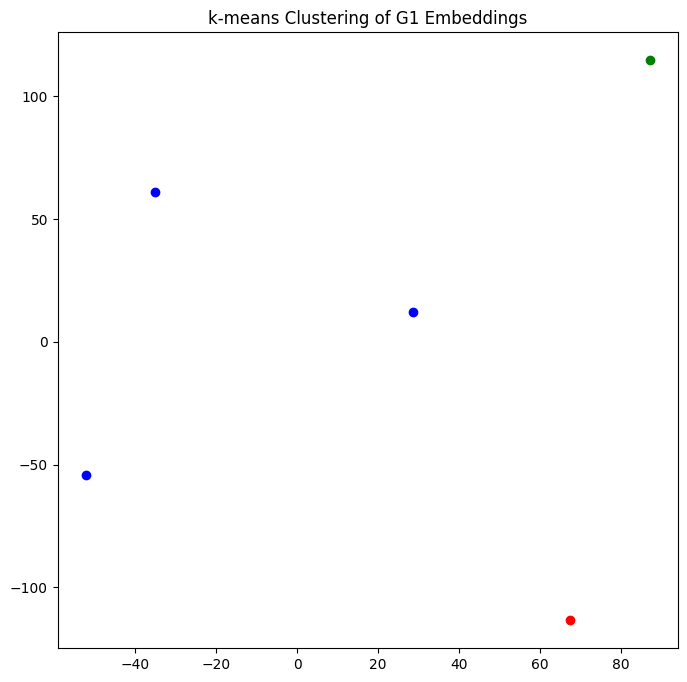

In [12]:
'''# 共通の埋め込みを学習するモデルの定義
class CommonEmbeddingModel(nn.Module):
    def __init__(self, g,input_dim, embedding_dim):
        super(CommonEmbeddingModel, self).__init__()
        self.embedding_layer = GraphConv(input_dim,embedding_dim)

    def forward(self, x):
        return self.embedding_layer(g,x)
'''
class CommonEmbeddingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CommonEmbeddingModel, self).__init__()
        self.embedding_layer = nn.Linear(input_dim, embedding_dim)

    def forward(self, x):
        return self.embedding_layer(x)
    
input_dim=10
# G1のダミーデータ（例）
G1_data = torch.randn((5, input_dim))

# G1の各ノードの埋め込みを取得
with torch.no_grad():
    embeddings_G1 = CommonEmbeddingModel(10,50)
    embeddings_G1 = embeddings_G1(G1_data)

# t-SNEを使用して埋め込みを2次元に削減
tsne = TSNE(n_components=2, random_state=42, perplexity=3)
embedded_G1 = tsne.fit_transform(embeddings_G1.numpy())

# k-meansクラスタリングを実行
num_clusters = 3  # クラスタ数
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_G1)

# クラスタリング結果を可視化
plt.figure(figsize=(8, 8))
for i in range(len(embedded_G1)):
    color = 'blue' if cluster_labels[i] == 0 else 'red' if cluster_labels[i] == 1 else 'green'
    plt.scatter(embedded_G1[i, 0], embedded_G1[i, 1], c=color)

plt.title('k-means Clustering of G1 Embeddings')
plt.show()


In [9]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)


In [10]:
print(X_embedded)

[[28.522013   29.439388  ]
 [20.06388     9.263902  ]
 [-0.20685318 17.538109  ]
 [ 8.21912    37.687954  ]]


In [4]:
# グラフの初期化
g = dgl.DGLGraph()
g.add_nodes(5)  # 5つのノードを追加

# エッジの追加（例：0から1、1から2、2から3、3から4、4から0へのエッジを追加）
src = [0, 1, 2, 3, 4,0,0]
dst = [1, 2, 3, 4, 0,2,4]
g.add_edges(src, dst)
g.ndata['f']=torch.randn((5,10))

/home/mi22a004/anaconda3/envs/DGL/lib/python3.10/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [3]:
dgl.sampling.node2vec_random_walk(g,[0,1,2],1,1,4)

tensor([[0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0],
        [2, 3, 4, 0, 1]])

In [10]:
import dgl
import torch
import dgl.nn as dglnn
from sklearn.cluster import KMeans

# Coraデータセットの読み込み
data = dgl.data.CoraGraphDataset()
g = data[0]


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [13]:
print(g.ndata['feat'].shape)

torch.Size([2708, 1433])


In [16]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.sage1 = dglnn.SAGEConv(in_feats=in_feats, out_feats=hidden_feats, aggregator_type='mean')
        self.sage2 = dglnn.SAGEConv(in_feats=hidden_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, g, features):
        x = self.sage1(g, features)
        x = torch.relu(x)
        x = self.sage2(g, x)
        x = torch.relu(x)
        return x
    

model = GraphSAGE(in_feats=1433, hidden_feats=128, out_feats=128)
# ノードの特徴量の取得
node_features = g.ndata['feat']

# グラフに特徴量を適用して埋め込みを学習
with torch.no_grad():
    emb = model(g, node_features)

# 学習された埋め込みを使用してクラスタリング
num_clusters = 10  # クラスタ数を指定
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(emb.cpu().numpy())

# 各ノードの所属クラスタを取得
cluster_labels = kmeans.labels_

# 結果の表示
for node, label in enumerate(cluster_labels):
    print(f"Node {node} belongs to cluster {label}")


/home/mi22a004/anaconda3/envs/DGL/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Node 0 belongs to cluster 0
Node 1 belongs to cluster 1
Node 2 belongs to cluster 3
Node 3 belongs to cluster 5
Node 4 belongs to cluster 7
Node 5 belongs to cluster 9
Node 6 belongs to cluster 9
Node 7 belongs to cluster 2
Node 8 belongs to cluster 6
Node 9 belongs to cluster 0
Node 10 belongs to cluster 9
Node 11 belongs to cluster 2
Node 12 belongs to cluster 1
Node 13 belongs to cluster 5
Node 14 belongs to cluster 1
Node 15 belongs to cluster 1
Node 16 belongs to cluster 9
Node 17 belongs to cluster 9
Node 18 belongs to cluster 5
Node 19 belongs to cluster 1
Node 20 belongs to cluster 0
Node 21 belongs to cluster 5
Node 22 belongs to cluster 4
Node 23 belongs to cluster 2
Node 24 belongs to cluster 5
Node 25 belongs to cluster 5
Node 26 belongs to cluster 4
Node 27 belongs to cluster 9
Node 28 belongs to cluster 8
Node 29 belongs to cluster 4
Node 30 belongs to cluster 5
Node 31 belongs to cluster 6
Node 32 belongs to cluster 6
Node 33 belongs to cluster 4
Node 34 belongs to clust

In [31]:
import dgl
import torch
import dgl.nn as dglnn
from dgl.dataloading import GraphDataLoader
import torch.nn as nn

'''# ダミーデータとしてラベル0のグラフ5つを作成
graphs = [dgl.graph(([0, 1, 1, 2], [1, 2, 3, 3])) for _ in range(5)]
# ランダムな特徴量をノードに割り当てる
for graph in graphs:
    graph = dgl.add_self_loop(graph)
    graph.ndata['feat'] = torch.randn(graph.num_nodes(), 1)
print(graphs)'''
graphs=[]
for _ in range(5):
    graph = dgl.graph(([0, 1, 1, 2], [1, 2, 3, 3]))
    graph = dgl.add_self_loop(graph)
    graph.ndata['feat'] = torch.randn(graph.num_nodes(), 1)
    graphs.append(graph)
# GCNモデルの定義
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats)
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats)

    def forward(self, g, features):
        x = torch.relu(self.conv1(g, features))
        x = self.conv2(g, x)
        g.ndata['h'] = x
        return dgl.mean_nodes(g,'h')

# モデルの初期化
model = GCN(in_feats=1, hidden_feats=16, out_feats=3)  # 仮の次元とクラス数

# グラフをバッチ化し、GCNにかけて埋め込みを取得
graphs_batched = dgl.batch(graphs)
#print(graphs_batched.ndata['feat'])
with torch.no_grad():
    embeddings = model(graphs_batched, graphs_batched.ndata['feat'])


'''# 生成した新しいグラフの構造を取得
new_graph = dgl.to_bidirected(graphs[0].clone())  # 新しいグラフの構造を学習したい場合、最初のグラフをクローンする

# 新しいグラフの埋め込みを取得
with torch.no_grad():
    new_embeddings = model(new_graph, new_graph.ndata['feat'])'''
# ラベル0の埋め込み表現
print("Label 0 Embedding:", embeddings)


Label 0 Embedding: tensor([[-0.1323,  0.1033, -0.1110],
        [ 0.0269,  0.1595, -0.2566],
        [-0.0179,  0.0638, -0.0922],
        [-0.3201,  0.1884, -0.1734],
        [ 0.1667,  0.2387, -0.4306]])


In [34]:
cos=nn.CosineSimilarity(1)
p0=torch.randn(5,10)
p1=torch.randn(10,10)

print(cos(p0,p1))

RuntimeError: The size of tensor a (5) must match the size of tensor b (10) at non-singleton dimension 0